In [5]:
!nvidia-smi

Tue Sep  7 05:15:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [7]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [8]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [29]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

import numpy as np

In [30]:
# random seed  설정
np.random.seed(0)
tf.random.set_seed(0)

### data loading

In [31]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

((60000, 28, 28), (10000, 28, 28))

### 하이퍼파라미터, 변수 설정

In [32]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

### 전처리, Dataset 생성
- X: 0 ~ 1 scaling
    - gray scale 일 경우 channel 축을 늘려줘야 한다.
- Y: onehot encoding

In [33]:
# 0 ~ 1 scaling
X_train_tmp = (train_image/255.0).astype(np.float32)
X_test_tmp = (test_image/255.0).astype(np.float32)

# channel 축을 추가
X_train = X_train_tmp[..., np.newaxis]
X_test = X_test_tmp[..., np.newaxis]

In [34]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [35]:
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [36]:
# Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

### Model(Network) 정의
- Feature Extraction:Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, widht) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [37]:
def create_mnist_model():
    model = keras.Sequential()
    # input layer - Convolution Layer 의 Input shape은 3차원으로 지정(height, width, channel). gray scale도 3차원으로 지정.
    model.add(layers.InputLayer((28, 28, 1))) #gray scale은 channel을 1로 지정.

    # convolution block
    # convolution layer: Conv2D()
    model.add(layers.Conv2D(filters=32,  #Filter(Kernel)의 개수
                            kernel_size=(3,3), # Filter shape (height, width) - height와 width가 같은 경우에는 하나만 써줘도 된다.
                            padding='same', #패딩 방식: "same", "valid"
                            strides=(1,1), #이동 간격. (상하,좌우) - 좌우/상하가 동일하면 하나만 써준다. default: (1,1)
                            activation='relu' #활성함수
                            ))
    
    # max pooling layer: MaxPool2D() - Feature Map의 size를 줄여주는 역할
    model.add(layers.MaxPool2D(pool_size=(2,2), # size (height, width)- height와 width가 같은 경우에는 하나만 써줘도 된다. (default=(2,2))
                               strides=(2,2), # 이동 간격(상하,좌우) - 동일할 경우 하나만 써도 된다. (default: pool_size값)
                               padding='same')) # same(을 사용), valid - same: 전체 input을 다 사용. , valid: 마지막에 남는 영역은 버린다.))

    model.add(layers.Conv2D(filters=64, # filter의 개수는 늘린다. == channel의 size는 늘린다.
                            kernel_size=3, # (3,3) => 같은 경우 정수로 지정, strides는 생략: default: 1
                            padding='same', #default: valid
                            activation='relu'
                            ))
    model.add(layers.MaxPool2D(padding='same')) #pool_size, strids 생략: 기본값 (2,2)

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # Dense Layer 추가
    # Flatten Layer 추가 - 3차원->1차원
    model.add(layers.Flatten())

    model.add(layers.Dense(units=256, activation='relu')) #Dense 레이어로 Hidden 추가.

    # 출력
    model.add(layers.Dense(units=10, activation='softmax')) #다중분류 출력레이어

    return model

### 모델 생성, 컴파일

In [38]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

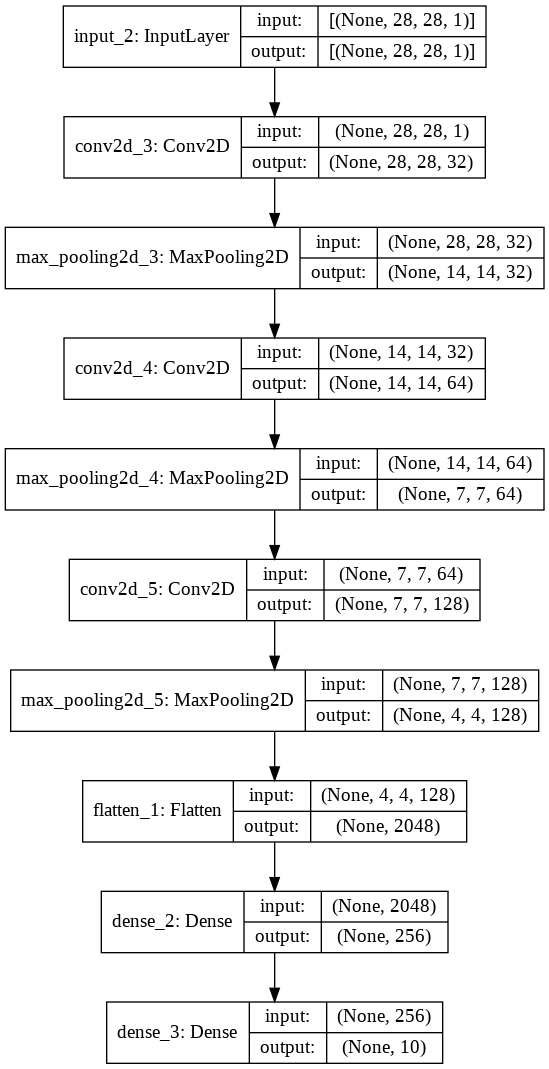

In [40]:
keras.utils.plot_model(model, show_shapes=True)

In [41]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 8s 13ms/step - loss: 0.1624 - accuracy: 0.9499 - val_loss: 0.0414 - val_accuracy: 0.9855
Epoch 2/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 3/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.0296 - val_accuracy: 0.9896
Epoch 4/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0259 - val_accuracy: 0.9909
Epoch 5/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 0.0284 - val_accuracy: 0.9915
Epoch 6/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0178 - val_accuracy: 0.9938
Epoch 7/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0257 - val_accuracy: 0.9924

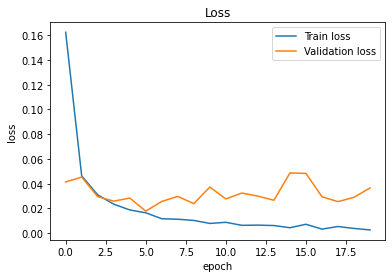

In [42]:
plot_loss(hist)

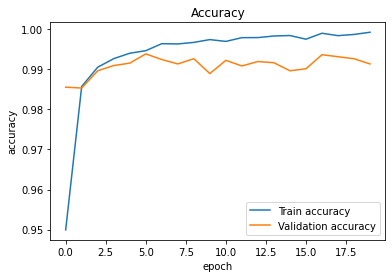

In [43]:
plot_accuracy(hist)

In [45]:
# 최종 검증
loss, acc = model.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.0366 - accuracy: 0.9913


In [46]:
print(loss, acc)

0.036583662033081055 0.9912999868392944


### prediction error가 발생한 example 확인

In [51]:
y = np.array([1,2,3,4,5,6])
p = np.array([1,2,6,4,5,1])
r = np.where(y!=p)[0]

p[r], y[r]

(array([6, 1]), array([3, 6]))

In [53]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [55]:
np.argmax(pred[0], axis=-1)

7

In [56]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [57]:
pred_label[:5]

array([7, 2, 1, 0, 4])

In [58]:
test_label.shape

(10000,)

In [61]:
idx = np.where(test_label != pred_label)[0]
idx.shape

(87,)

In [63]:
idx

array([  62,  241,  340,  445,  448,  582,  593,  646,  659,  882, 1014,
       1039, 1112, 1178, 1182, 1232, 1242, 1260, 1393, 1459, 1522, 1553,
       1559, 1621, 1709, 1732, 1878, 1901, 1952, 1982, 2129, 2130, 2182,
       2225, 2414, 2447, 2462, 2597, 2654, 2771, 2810, 2915, 2939, 3023,
       3225, 3422, 3504, 3534, 3558, 3597, 3727, 3762, 3808, 3871, 3926,
       3941, 4001, 4078, 4176, 4199, 4238, 4284, 4360, 4505, 4761, 4807,
       4838, 4860, 5634, 5937, 6166, 6173, 6560, 6571, 6576, 6578, 6597,
       7847, 7856, 7900, 7928, 7991, 8408, 9009, 9642, 9664, 9692])

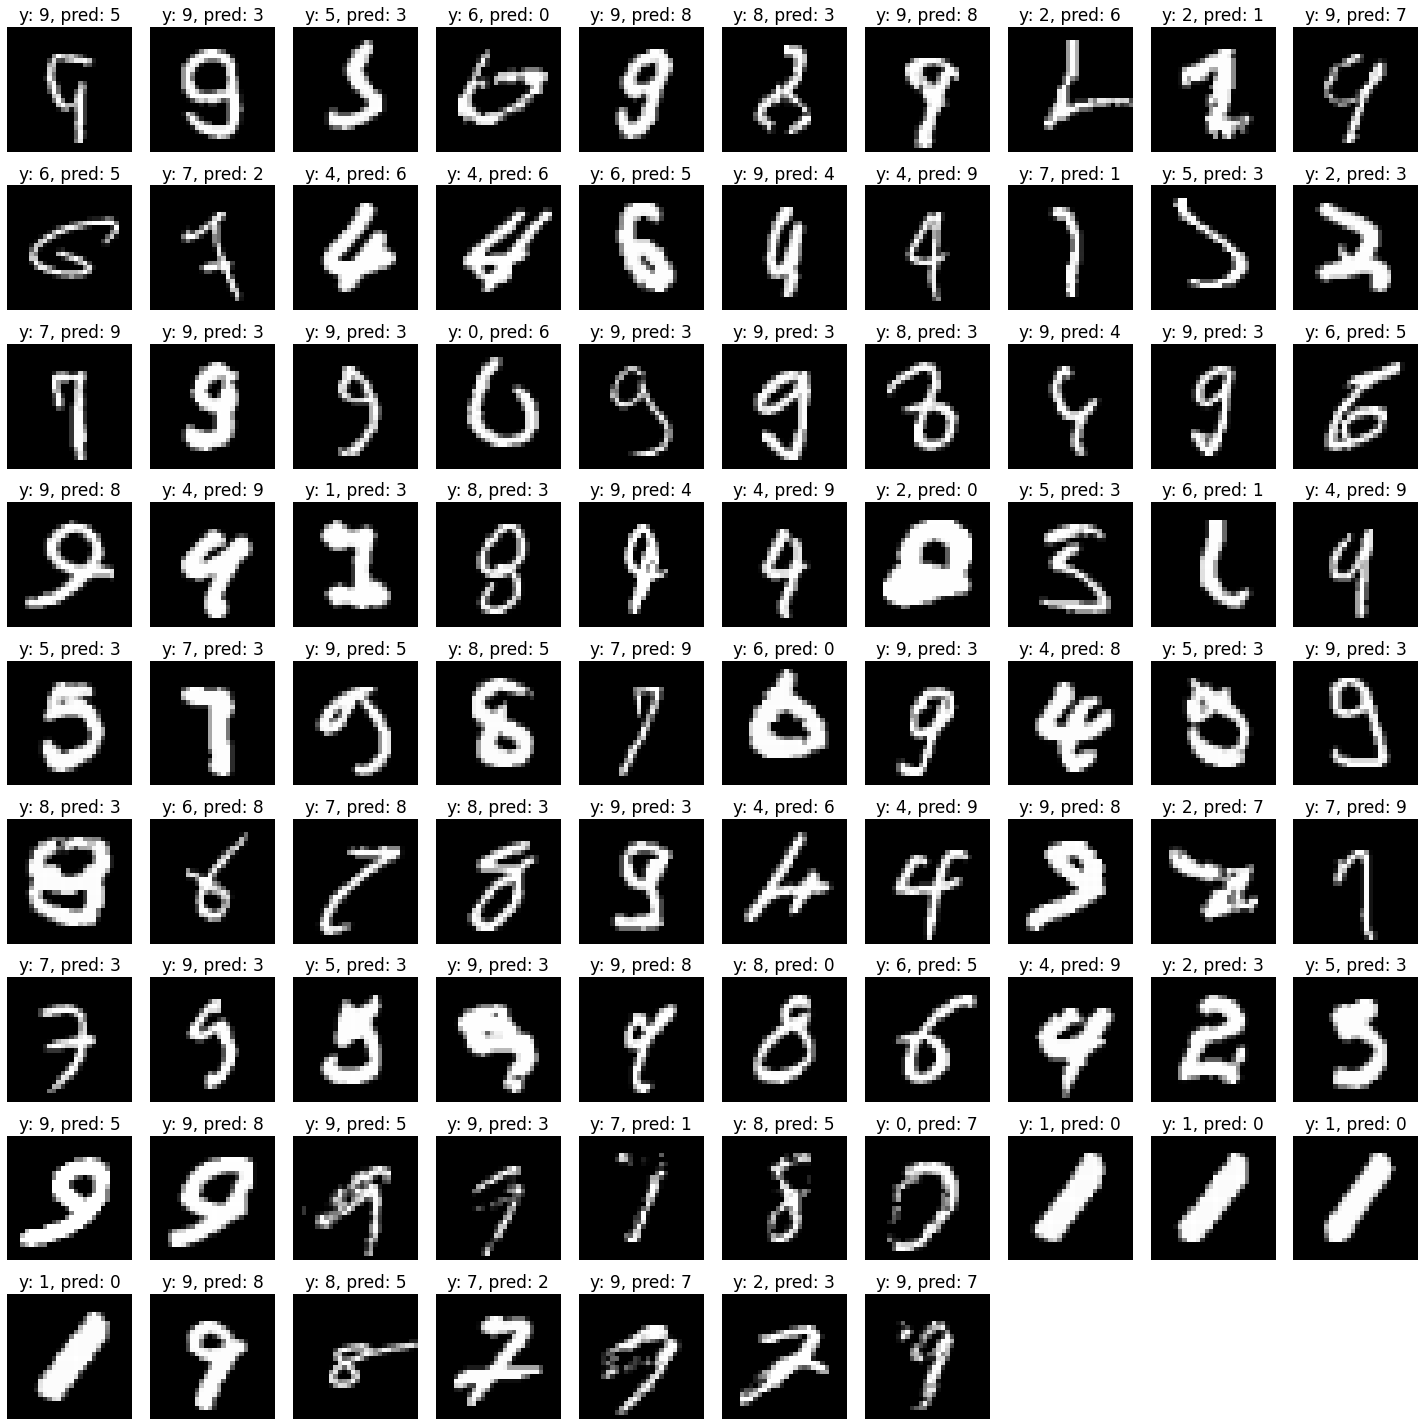

In [69]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i in range(90):
    if i == 87:
        break
    error_idx = idx[i]
    
    p = pred_label[error_idx] #예측
    y = test_label[error_idx] #정답

    plt.subplot(9, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title("y: {}, pred: {}".format(y, p), fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**